In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from pathlib import Path

# Reading data and preprocessing

In [11]:
def preprocess_image(img, img_size=25):
    """Turn image from disk into a model-ready format (4-dimension)"""
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale image
    img = cv2.resize(img, (img_size, img_size)).astype(np.float32) # resize down to a small image
    img /= 255 # normalize to [0,1] range
    img = img[np.newaxis, ..., np.newaxis] # add batch dimension and color channel dimension
    return img

def read_and_plot_images(folder):
    images = []
    plt.figure(figsize=(20,10))
    for i, filename in enumerate(Path(folder).iterdir()):
        img = cv2.imread(str(filename))
        img = preprocess_image(img)
        images.append(img)
        plt.subplot(5, 10, i+1)
        plt.imshow(np.squeeze(img), cmap='gray')
    images = np.concatenate(images)
    plt.show()
    return images

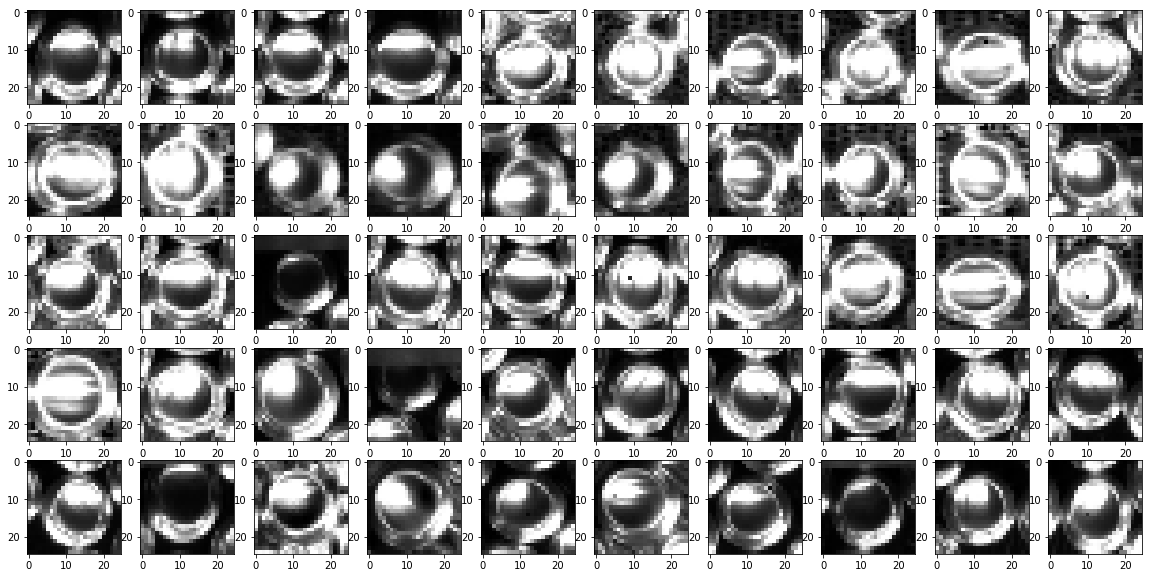

In [12]:
positive_images = read_and_plot_images('positive')

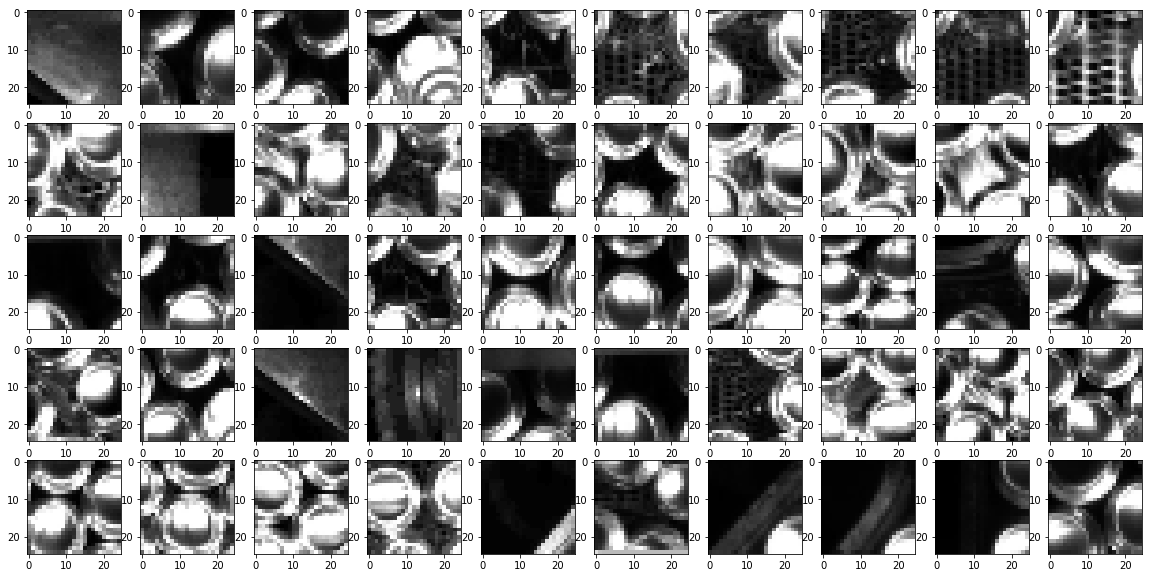

In [13]:
negative_images = read_and_plot_images('negative')

In [24]:
print(positive_images.shape, positive_images.dtype)
print(negative_images.shape, negative_images.dtype)

(50, 25, 25, 1) float32
(50, 25, 25, 1) float32


In [25]:
# join positive and negative together
X = np.concatenate([positive_images, negative_images])
y = np.concatenate([np.ones(positive_images.shape[0]),
                    np.zeros(negative_images.shape[0])])
print(X.shape, y.shape)

(100, 25, 25, 1) (100,)


# Train/Test split

In [26]:
test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(90, 25, 25, 1) (10, 25, 25, 1) (90,) (10,)


# Deep learning

In [27]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=2, activation='relu', input_shape=X_train.shape[1:]),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=2, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model.summary()
model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.input_shape, model.output_shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 12, 12, 16)        160       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 5, 16)          2320      
_________________________________________________________________
flatten_3 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                25664     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 28,209
Trainable params: 28,209
Non-trainable params: 0
_________________________________________________________________
(None, 25, 25, 1) (None, 1)


In [28]:
model.fit(X_train, y_train, epochs=30, validation_split=0.1)

Train on 81 samples, validate on 9 samples
Epoch 1/30
81/81 [==============================] - 0s 5ms/step - loss: 0.6755 - acc: 0.6173 - val_loss: 0.6056 - val_acc: 0.8889
Epoch 2/30
81/81 [==============================] - 0s 123us/step - loss: 0.6328 - acc: 0.7407 - val_loss: 0.5437 - val_acc: 0.8889
Epoch 3/30
81/81 [==============================] - 0s 123us/step - loss: 0.5893 - acc: 0.7407 - val_loss: 0.4851 - val_acc: 0.8889
Epoch 4/30
81/81 [==============================] - 0s 123us/step - loss: 0.5365 - acc: 0.8148 - val_loss: 0.4389 - val_acc: 1.0000
Epoch 5/30
81/81 [==============================] - 0s 111us/step - loss: 0.4739 - acc: 0.9136 - val_loss: 0.4182 - val_acc: 1.0000
Epoch 6/30
81/81 [==============================] - 0s 136us/step - loss: 0.4319 - acc: 0.9506 - val_loss: 0.3706 - val_acc: 1.0000
Epoch 7/30
81/81 [==============================] - 0s 135us/step - loss: 0.3588 - acc: 0.9506 - val_loss: 0.2537 - val_acc: 1.0000
Epoch 8/30
81/81 [=================

# Evaluation on test set

In [29]:
loss, acc = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", acc*100, '%')

10/10 [==============================] - 0s 97us/step
Loss: 0.09720472991466522
Accuracy: 100.0 %


# Detection

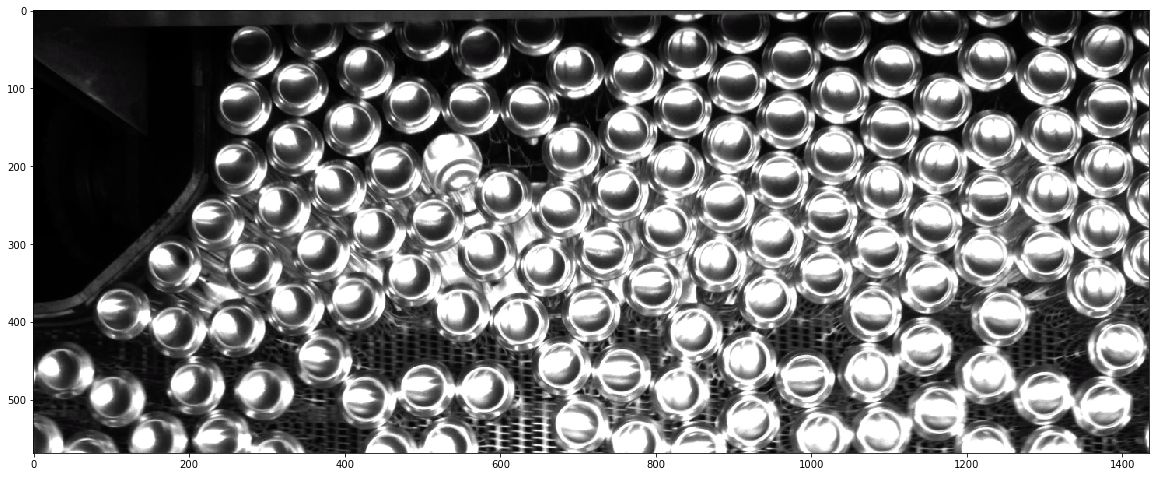

(569, 1435, 3)


In [38]:
image_path = 'img/cylinder.png'
big_img = cv2.imread(image_path)
plt.figure(figsize=(20,10))
plt.imshow(big_img)
plt.show()
print(big_img.shape)

In [64]:
crop_size = 90
strides = 15

In [77]:
%%time
X_candidate = []
for r in range(0, big_img.shape[0], strides):
    for c in range(0, big_img.shape[1], strides):
        img = big_img[r:r+crop_size, c:c+crop_size]
        if img.shape[:2] != (crop_size, crop_size): # check if is boundary crop
            break
        img = preprocess_image(img)
        X_candidate.append(img)
#         plt.imshow(img)
#         plt.show()
X_candidate = np.concatenate(X_candidate)
print(candidates.shape)

(2880, 25, 25, 1)
Wall time: 65.8 ms


In [84]:
%time pred_prob = model.predict(candidates)

threshold = 0.5 # confidence decision threshold
pred_binary = pred_prob >= threshold
print("Positive predictions:", np.count_nonzero(pred_binary))
print("Negative predictions:", np.count_nonzero(~pred_binary))

Wall time: 88.8 ms
Positive predictions: 617
Negative predictions: 2263
